In [1]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings("ignore")

**Data Loading and Prep**

In [2]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [4]:
df.stroke.value_counts()

0    4861
1     249
Name: stroke, dtype: int64

In [5]:
df.columns.tolist()

['id',
 'gender',
 'age',
 'hypertension',
 'heart_disease',
 'ever_married',
 'work_type',
 'Residence_type',
 'avg_glucose_level',
 'bmi',
 'smoking_status',
 'stroke']

In [6]:
# selecting severals columns only for pipeline demonstration
col = ['stroke', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'smoking_status']
num = ['age', 'avg_glucose_level', 'bmi']
cat = [i for i in col if i not in num]

df_exp = df[col].copy()

In [7]:
df_exp

,stroke,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status
0,1,67.0,0,1,228.69,36.6,formerly smoked
1,1,61.0,0,0,202.21,NaN,never smoked
2,1,80.0,0,1,105.92,32.5,never smoked
3,1,49.0,0,0,171.23,34.4,smokes
4,1,79.0,1,0,174.12,24.0,never smoked
...,...,...,...,...,...,...,...
5105,0,80.0,1,0,83.75,NaN,never smoked
5106,0,81.0,0,0,125.20,40.0,never smoked
5107,0,35.0,0,0,82.99,30.6,never smoked
5108,0,51.0,0,0,166.29,25.6,formerly smoked


**Split dataset**

In [8]:
X = df_exp.drop('stroke', axis=1)
y = df_exp['stroke']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=0)

In [10]:
for i in [X_train, X_test, y_train, y_test]:
    print(f'shape: {i.shape}')

shape: (4088, 6)
shape: (1022, 6)
shape: (4088,)
shape: (1022,)


In [11]:
X_train

,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status
943,75.0,0,0,86.40,42.6,never smoked
821,70.0,1,0,88.66,36.7,formerly smoked
4675,8.0,0,0,63.43,21.8,Unknown
3737,73.0,0,0,98.69,27.6,Unknown
2067,40.0,0,0,212.97,49.8,formerly smoked
...,...,...,...,...,...,...
4655,10.0,0,0,57.28,15.4,never smoked
3126,54.0,0,0,114.61,40.1,formerly smoked
3896,31.0,0,0,102.39,22.9,smokes
1099,34.0,0,0,85.57,26.8,Unknown


In [12]:
y_train.value_counts()

0    3889
1     199
Name: stroke, dtype: int64

Our training data consists of 4088 rows, with imbalance target. minority class < 10%

**Simple EDA**

In [13]:
num = ['age', 'avg_glucose_level', 'bmi']
cat = [i for i in X_train.columns.tolist() if i not in num]

In [14]:
X_train[num].head()

,age,avg_glucose_level,bmi
943,75.0,86.40,42.6
821,70.0,88.66,36.7
4675,8.0,63.43,21.8
3737,73.0,98.69,27.6
2067,40.0,212.97,49.8


In [15]:
for i in X_train[cat].columns.tolist():
    print(X_train[i].value_counts())
    print('-'*50)

0    3686
1     402
Name: hypertension, dtype: int64
--------------------------------------------------
0    3871
1     217
Name: heart_disease, dtype: int64
--------------------------------------------------
never smoked       1506
Unknown            1253
formerly smoked     710
smokes              619
Name: smoking_status, dtype: int64
--------------------------------------------------


**pipeline without imbalance handling**

In [16]:
num_pipeline = Pipeline([
                    ('impute MV', SimpleImputer(strategy="median")),
                    ('scaling', StandardScaler()),
                    ('pca', PCA(n_components=0.85))
                ])

cat_pipeline = Pipeline([
                    ('encode', OrdinalEncoder(categories=[[0, 1],
                               [0, 1], 
                               ['never smoked', 'Unknown', 'formerly smoked', 'smokes']]))
                ])

final_prep = ColumnTransformer([
        ("num", num_pipeline, num),
        ("cat", cat_pipeline, cat),
    ])

In [17]:
final_prep.fit_transform(X_train)

array([[ 1.7130635 ,  1.53570812, -0.04880152,  0.        ,  0.        ,
         0.        ],
       [ 1.15036999,  1.05796462, -0.34281801,  1.        ,  0.        ,
         2.        ],
       [-1.99007574,  0.04241741,  0.39354817,  0.        ,  0.        ,
         1.        ],
       ...,
       [-0.83031556, -0.43018627, -0.08452263,  0.        ,  0.        ,
         3.        ],
       [-0.63858615,  0.16890935,  0.04308407,  0.        ,  0.        ,
         1.        ],
       [ 1.42614197, -1.22969886, -0.47628008,  1.        ,  0.        ,
         2.        ]])

In [18]:
no_imb = pd.DataFrame(final_prep.fit_transform(X_train), columns=num+cat)

pd.concat([no_imb, y_train.reset_index(drop=True)], axis=1)

,age,avg_glucose_level,bmi,hypertension,heart_disease,smoking_status,stroke
0,1.713064,1.535708,-0.048802,0.0,0.0,0.0,0
1,1.150370,1.057965,-0.342818,1.0,0.0,2.0,0
2,-1.990076,0.042417,0.393548,0.0,0.0,1.0,0
3,0.653645,0.282806,-1.117999,0.0,0.0,1.0,0
4,2.706171,-0.613096,2.318663,0.0,0.0,2.0,0
...,...,...,...,...,...,...,...
4083,-2.490436,-0.257480,-0.214198,0.0,0.0,0.0,0
4084,1.255048,0.677773,0.588127,0.0,0.0,2.0,0
4085,-0.830316,-0.430186,-0.084523,0.0,0.0,3.0,0
4086,-0.638586,0.168909,0.043084,0.0,0.0,1.0,0


**pipeline with imbalance handling**

In [19]:
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline as imbpipe

num_pipeline = Pipeline([
                    ('impute MV', SimpleImputer(strategy="median")),
                    ('scaling', StandardScaler()),
                    ('pca', PCA(n_components=0.85))
                ])

cat_pipeline = Pipeline([
                    ('encode', OrdinalEncoder(categories=[[0, 1],
                               [0, 1], 
                               ['never smoked', 'Unknown', 'formerly smoked', 'smokes']]))
                ])

final_prep = ColumnTransformer([
        ("num", num_pipeline, num),
        ("cat", cat_pipeline, cat),
    ])

# imbalance pipeline
final = imbpipe([
            ('preprocess', final_prep),
            ('over_sampl', SMOTENC([3, 4, 5], sampling_strategy=0.5, random_state=0))
])

In [20]:
X_resampled, y_resampled = final.fit_resample(X_train, y_train)
# pd.DataFrame(X_resampled, columns=X_train.columns.tolist())
# pd.DataFrame(y_resampled)
resampled = pd.concat([pd.DataFrame(X_resampled, columns=X_train.columns.tolist()), pd.DataFrame(y_resampled)], axis=1)
resampled

,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,stroke
0,1.713064,1.535708,-0.048802,0.0,0.0,0.0,0
1,1.150370,1.057965,-0.342818,1.0,0.0,2.0,0
2,-1.990076,0.042417,0.393548,0.0,0.0,1.0,0
3,0.653645,0.282806,-1.117999,0.0,0.0,1.0,0
4,2.706171,-0.613096,2.318663,0.0,0.0,2.0,0
...,...,...,...,...,...,...,...
5828,2.339128,-1.637489,-0.505101,0.0,1.0,0.0,1
5829,0.155149,0.607362,-0.958404,1.0,0.0,3.0,1
5830,0.364987,1.070684,-1.422722,0.0,0.0,2.0,1
5831,2.198608,-1.079591,0.418177,0.0,1.0,2.0,1


In [21]:
resampled.stroke.value_counts()

0    3889
1    1944
Name: stroke, dtype: int64

## **Pipeline: Preprocess + Prediction**

**without imbalance handling**

In [22]:
# preprocess
num_pipeline = Pipeline([
                    ('impute MV', SimpleImputer(strategy="median")),
                    ('scaling', StandardScaler()),
                    ('pca', PCA(n_components=0.85))
                ])

cat_pipeline = Pipeline([
                    ('encode', OrdinalEncoder(categories=[[0, 1],
                               [0, 1], 
                               ['never smoked', 'Unknown', 'formerly smoked', 'smokes']]))
                ])

final_prep = ColumnTransformer([
        ("num", num_pipeline, num),
        ("cat", cat_pipeline, cat),
    ])

# preprocess + model
full_no_imbhandling = Pipeline([
                        ('preprocess', final_prep),
                        ('logreg', LogisticRegression(random_state=0))
])

In [29]:
full_no_imbhandling.fit(X_train, y_train)

# evaluate on test
pred = full_no_imbhandling.predict(X_test)
print(classification_report(y_test, pred))
print(confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98       972
           1       1.00      0.02      0.04        50

    accuracy                           0.95      1022
   macro avg       0.98      0.51      0.51      1022
weighted avg       0.95      0.95      0.93      1022

[[972   0]
 [ 49   1]]


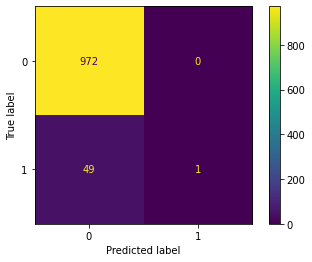

In [30]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(full_no_imbhandling, X_test, y_test)

**with imbalance handling**

In [24]:
num_pipeline = Pipeline([
                    ('impute MV', SimpleImputer(strategy="median")),
                    ('scaling', StandardScaler()),
                    ('pca', PCA(n_components=0.85))
                ])

cat_pipeline = Pipeline([
                    ('encode', OrdinalEncoder(categories=[[0, 1],
                               [0, 1], 
                               ['never smoked', 'Unknown', 'formerly smoked', 'smokes']]))
                ])

final_prep = ColumnTransformer([
        ("num", num_pipeline, num),
        ("cat", cat_pipeline, cat),
    ])

# imbalance pipeline
full_imbhandling = imbpipe([
            ('preprocess', final_prep),
            ('over_sampl', SMOTENC([3, 4, 5], sampling_strategy=0.5, random_state=0)),
            ('logreg', LogisticRegression(random_state=0))
])

In [27]:
full_imbhandling.fit(X_train, y_train)

# evaluate on test
handled_pred = full_imbhandling.predict(X_test)

print(classification_report(y_test, handled_pred))
print(confusion_matrix(y_test, handled_pred))

              precision    recall  f1-score   support

           0       0.97      0.85      0.91       972
           1       0.16      0.54      0.25        50

    accuracy                           0.84      1022
   macro avg       0.57      0.70      0.58      1022
weighted avg       0.93      0.84      0.88      1022

[[829 143]
 [ 23  27]]


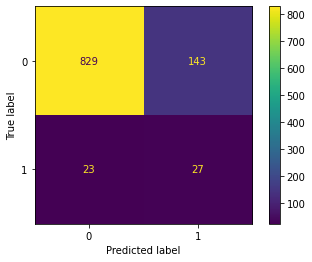

In [31]:
plot_confusion_matrix(full_imbhandling, X_test, y_test)

**notes**

In [26]:
# imbalance pipe
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline as imbpipe

imb = imbpipe([
        ('smtnc', SMOTENC([3, 4, 5], sampling_strategy=0.7, random_state=0)),
        ('linreg', LogisticRegression(random_state=0))
])

final = Pipeline([
        ('prep', final_prep),
        ('pred', imb)
])